In [1]:
import sys
sys.path.append("../../")

from src.statistics.cointegration import find_cointegrated_pairs, analyze_pairs, plot_cointegration_heatmap
from datetime import datetime, timedelta
import pandas as pd
import numpy as np
from statsmodels.tsa.stattools import coint
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm
import warnings
import statsmodels.api as sm

warnings.filterwarnings('ignore')

DATE_CONFIG = {
    'TRAIN_START': pd.Timestamp('2021-02-02'),
    'TRAIN_END': pd.Timestamp('2024-01-01'),
    'TEST_END': pd.Timestamp('2025-01-01'),
    'TRADING_DAYS_PER_YEAR': 252  
}

def get_training_period():
    return {
        'start': DATE_CONFIG['TRAIN_START'],
        'end': DATE_CONFIG['TRAIN_END']
    }

def get_test_period():
    return {
        'start': DATE_CONFIG['TRAIN_END'],
        'end': DATE_CONFIG['TEST_END']
    }

def get_training_days():
    years = (DATE_CONFIG['TRAIN_END'] - DATE_CONFIG['TRAIN_START']).days / 365
    return int(years * DATE_CONFIG['TRADING_DAYS_PER_YEAR'])

plt.style.use('classic')
plt.rcParams['figure.figsize'] = [12, 6]
plt.rcParams['figure.dpi'] = 100

In [2]:
p_threshold = 0.05
min_pairs = 20

window_shifts = 12
shift_size = 1

bb_window = 50
std_dev = 1.5
hr_window = 25 
hr_recalc = 3  

learning_rate = 0.2
max_depth = 2
min_samples_leaf = 2
min_samples_split = 2
n_estimators = 300

base_input_path = "../../data/raw/" 
input_filename = "nasdaq_daily.parquet" 
base_output_path = "../../data/results/" 
output_filename = "GradientBoost_Bollinger_Sliding.parquet"

In [3]:
def load_and_prepare_data(file_path):
    df = pd.read_parquet(file_path)
    df['date'] = pd.to_datetime(df['date'])
    
    mask = (df['date'] >= DATE_CONFIG['TRAIN_START']) & \
           (df['date'] <= DATE_CONFIG['TEST_END'])
    df = df[mask]
    
    price_matrix = df.pivot(index='date', columns='symbol', values='close')
    volume_matrix = df.pivot(index='date', columns='symbol', values='volume')
    
    symbols = price_matrix.columns.tolist()
    
    print(f"Loaded data from {DATE_CONFIG['TRAIN_START']} to {DATE_CONFIG['TEST_END']}")
    print(f"Total symbols: {len(symbols)}")
    print(f"Total trading days: {len(price_matrix)}")
    
    return price_matrix, volume_matrix, symbols

In [4]:
input_data_path = f"{base_input_path}{input_filename}"
price_matrix, volume_matrix, symbols = load_and_prepare_data(input_data_path)

Loaded data from 2021-02-02 00:00:00 to 2025-01-01 00:00:00
Total symbols: 94
Total trading days: 985


In [5]:
returns_matrix = price_matrix.pct_change()
returns_matrix = returns_matrix.dropna() 

In [6]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
standardized_returns = pd.DataFrame(
    scaler.fit_transform(returns_matrix),
    index=returns_matrix.index,
    columns=returns_matrix.columns
)

In [7]:
def calculate_rolling_correlation(returns_df, window=250):
    pairs_corr = {}
    symbols = returns_df.columns
    
    for i in range(len(symbols)):
        for j in range(i+1, len(symbols)):
            sym1, sym2 = symbols[i], symbols[j]
            pair_key = f"{sym1}_{sym2}"
            
            rolling_corr = returns_df[[sym1, sym2]].rolling(window=window)\
                          .corr()\
                          .unstack()[sym2][sym1]
                          
            pairs_corr[pair_key] = rolling_corr
            
    return pd.DataFrame(pairs_corr)

rolling_correlations = calculate_rolling_correlation(standardized_returns)
rolling_correlations = rolling_correlations.dropna()

In [8]:
def calculate_rolling_betas(returns_df, window=250):
    pairs_beta = {}
    symbols = returns_df.columns
    
    for i in range(len(symbols)):
        for j in range(i+1, len(symbols)):
            sym1, sym2 = symbols[i], symbols[j]
            pair_key = f"{sym1}_{sym2}"
            
            x = returns_df[sym2]
            y = returns_df[sym1]
            
            rolling_cov = y.rolling(window=window).cov(x)
            rolling_var = x.rolling(window=window).var()
            rolling_beta = rolling_cov / rolling_var
            
            pairs_beta[pair_key] = rolling_beta
            
    return pd.DataFrame(pairs_beta)

rolling_betas = calculate_rolling_betas(standardized_returns)
rolling_betas = rolling_betas.dropna()

In [9]:
def calculate_residuals_std(returns_df, window=250):
    pairs_residuals = {}
    symbols = returns_df.columns
    
    for i in range(len(symbols)):
        for j in range(i+1, len(symbols)):
            sym1, sym2 = symbols[i], symbols[j]
            pair_key = f"{sym1}_{sym2}"
            
            x = returns_df[sym2].values
            y = returns_df[sym1].values
            
            residuals = [np.nan] * len(returns_df)
            for k in range(window, len(returns_df) + 1):
                window_x = x[k-window:k]
                window_y = y[k-window:k]
                coeffs = np.polyfit(window_x, window_y, 1)
                pred = np.polyval(coeffs, window_x)
                window_residuals = window_y - pred
                residuals[k-1] = np.std(window_residuals)
                
            pairs_residuals[pair_key] = residuals
            
    return pd.DataFrame(pairs_residuals, index=returns_df.index)

rolling_residuals_std = calculate_residuals_std(standardized_returns)
rolling_residuals_std = rolling_residuals_std.dropna()

In [10]:
def calculate_spread_deviation(returns_df, window=250, holding_period=5, zscore_threshold=2):
    pairs_spread_dev = {}
    symbols = returns_df.columns
    
    for i in range(len(symbols)):
        for j in range(i+1, len(symbols)):
            sym1, sym2 = symbols[i], symbols[j]
            pair_key = f"{sym1}_{sym2}"
            
            spread = returns_df[sym1] - returns_df[sym2]
            rolling_mean = spread.rolling(window=window).mean()
            rolling_std = spread.rolling(window=window).std()
            zscore = (spread - rolling_mean) / rolling_std
            
            entry_signals = abs(zscore) > zscore_threshold
            spread_changes = []
            
            for k in range(window, len(returns_df) - holding_period):
                if entry_signals.iloc[k]:
                    spread_t0 = spread.iloc[k]
                    spread_t1 = spread.iloc[k + holding_period]
                    spread_change = abs(spread_t1 - spread_t0)
                    spread_changes.append(spread_change)
            
            if spread_changes:
                pairs_spread_dev[pair_key] = np.mean(spread_changes)
            else:
                pairs_spread_dev[pair_key] = np.nan
                
    return pd.Series(pairs_spread_dev)

average_spread_deviation = calculate_spread_deviation(standardized_returns)
average_spread_deviation = average_spread_deviation.dropna()

print(f"Anzahl der berechneten Paare: {len(average_spread_deviation)}")
print("\nTop 5 Paare mit niedrigster Spread-Abweichung:")
print(average_spread_deviation.nsmallest(5))

Anzahl der berechneten Paare: 4371

Top 5 Paare mit niedrigster Spread-Abweichung:
GOOG_GOOGL    0.189896
AMAT_LRCX     0.953922
KLAC_LRCX     1.136990
AMAT_KLAC     1.218381
MCHP_NXPI     1.360034
dtype: float64


In [11]:
feature_df = pd.DataFrame({
   'correlation': rolling_correlations.iloc[-1],
   'beta': rolling_betas.iloc[-1],
   'residuals_std': rolling_residuals_std.iloc[-1]
})

feature_df['target'] = average_spread_deviation
feature_df = feature_df.dropna()

In [12]:
def calculate_volume_features(volume_df, pairs, windows=[50, 100]):
    features = {}
    
    for pair in pairs:
        sym1, sym2 = pair.split('_')
        pair_features = {}
        
        for window in windows:
            vol1 = volume_df[sym1].rolling(window=window)
            vol2 = volume_df[sym2].rolling(window=window)
            
            pair_features[f'vol_avg_{window}'] = ((vol1.mean() + vol2.mean()) / 2).iloc[-1]
            pair_features[f'vol_std_{window}'] = ((vol1.std() + vol2.std()) / 2).iloc[-1]
            pair_features[f'vol_change_{window}'] = ((volume_df[sym1].pct_change() + volume_df[sym2].pct_change()) / 2).rolling(window=window).mean().iloc[-1]
        
        features[pair] = pair_features
    
    return pd.DataFrame.from_dict(features, orient='index')

In [13]:
volume_features = calculate_volume_features(volume_matrix, rolling_correlations.columns)

feature_df = pd.concat([
    feature_df[['correlation', 'beta', 'residuals_std', 'target']],
    volume_features,
], axis=1)

In [14]:
def calculate_roc_features(price_df, volume_df, pairs, windows=[5, 20, 50]):
    features = {}
    
    for pair in pairs:
        sym1, sym2 = pair.split('_')
        pair_features = {}
        
        for window in windows:
            # Price ROC
            price_roc_1 = price_df[sym1].pct_change(window)
            price_roc_2 = price_df[sym2].pct_change(window)
            
            pair_features[f'ROC_SYM1_{window}d'] = price_roc_1.iloc[-1]
            pair_features[f'ROC_SYM2_{window}d'] = price_roc_2.iloc[-1]
            pair_features[f'ROC_diff_{window}d'] = price_roc_1.iloc[-1] - price_roc_2.iloc[-1]
            
            # Volume ROC
            vol_roc_1 = volume_df[sym1].pct_change(window)
            vol_roc_2 = volume_df[sym2].pct_change(window)
            
            pair_features[f'vol_ROC_SYM1_{window}d'] = vol_roc_1.iloc[-1]
            pair_features[f'vol_ROC_SYM2_{window}d'] = vol_roc_2.iloc[-1]
            pair_features[f'vol_ROC_diff_{window}d'] = vol_roc_1.iloc[-1] - vol_roc_2.iloc[-1]
        
        features[pair] = pair_features
    
    return pd.DataFrame.from_dict(features, orient='index')

In [15]:
roc_features = calculate_roc_features(price_matrix, volume_matrix, rolling_correlations.columns)

feature_df = pd.concat([
    feature_df,
    roc_features
], axis=1)

In [16]:
def calculate_williams_r_features(price_df, pairs, windows=[10, 14, 28, 40]):
   features = {}
   
   for pair in pairs:
       sym1, sym2 = pair.split('_')
       pair_features = {}
       
       for window in windows:
           # Williams %R für Symbol 1
           high1 = price_df[sym1].rolling(window=window).max()
           low1 = price_df[sym1].rolling(window=window).min()
           williams_r1 = ((high1 - price_df[sym1]) / (high1 - low1) * -100)
           
           # Williams %R für Symbol 2
           high2 = price_df[sym2].rolling(window=window).max()
           low2 = price_df[sym2].rolling(window=window).min()
           williams_r2 = ((high2 - price_df[sym2]) / (high2 - low2) * -100)
           
           pair_features[f'WilliamsR_SYM1_{window}d'] = williams_r1.iloc[-1]
           pair_features[f'WilliamsR_SYM2_{window}d'] = williams_r2.iloc[-1]
           pair_features[f'WilliamsR_diff_{window}d'] = williams_r1.iloc[-1] - williams_r2.iloc[-1]
       
       features[pair] = pair_features
   
   return pd.DataFrame.from_dict(features, orient='index')

In [17]:
williams_r_features = calculate_williams_r_features(price_matrix, rolling_correlations.columns)

feature_df = pd.concat([
    feature_df,
    williams_r_features
], axis=1)

In [18]:
def calculate_bollinger_bands_width(returns_df, pairs, windows=[5, 10, 20, 25, 50]):
    features = {}
    
    for pair in pairs:
        sym1, sym2 = pair.split('_')
        pair_features = {}
        
        spread = returns_df[sym1] - returns_df[sym2]
        
        for window in windows:
            sma = spread.rolling(window=window).mean()
            std = spread.rolling(window=window).std()
            
            bb_width = (2 * std) / sma * 100
            pair_features[f'BB_width_{window}d'] = bb_width.iloc[-1]
        
        features[pair] = pair_features
    
    return pd.DataFrame.from_dict(features, orient='index')

In [19]:
bollinger_bands_features = calculate_bollinger_bands_width(standardized_returns, rolling_correlations.columns)

feature_df = pd.concat([
    feature_df,
    bollinger_bands_features
], axis=1)

In [20]:
def calculate_macd_features(price_df, pairs, params=[
    {'fast': 12, 'slow': 26, 'signal': 9},
    {'fast': 5, 'slow': 13, 'signal': 5}
]):
    features = {}
    
    for pair in pairs:
        sym1, sym2 = pair.split('_')
        pair_features = {}
        
        for p in params:
            period = f"{p['fast']}_{p['slow']}_{p['signal']}"
            
            for sym in [sym1, sym2]:
                fast_ema = price_df[sym].ewm(span=p['fast']).mean()
                slow_ema = price_df[sym].ewm(span=p['slow']).mean()
                macd_line = fast_ema - slow_ema
                signal_line = macd_line.ewm(span=p['signal']).mean()
                histogram = macd_line - signal_line
                
                if sym == sym1:
                    macd_line_1 = macd_line
                    signal_line_1 = signal_line
                    histogram_1 = histogram
                else:
                    macd_line_2 = macd_line
                    signal_line_2 = signal_line
                    histogram_2 = histogram
            
            pair_features[f'MACD_line_diff_{period}'] = (macd_line_1 - macd_line_2).iloc[-1]
            pair_features[f'Signal_line_diff_{period}'] = (signal_line_1 - signal_line_2).iloc[-1]
            pair_features[f'MACD_hist_diff_{period}'] = (histogram_1 - histogram_2).iloc[-1]
            pair_features[f'MACD_cross_{period}_SYM1'] = 1 if macd_line_1.iloc[-1] > signal_line_1.iloc[-1] else 0
            pair_features[f'MACD_cross_{period}_SYM2'] = 1 if macd_line_2.iloc[-1] > signal_line_2.iloc[-1] else 0
        
        features[pair] = pair_features
    
    return pd.DataFrame.from_dict(features, orient='index')

In [21]:
macd_features = calculate_macd_features(price_matrix, rolling_correlations.columns)

feature_df = pd.concat([
    feature_df,
    macd_features
], axis=1)

##### Grid Search 
```Python
param_grid = {
    'n_estimators': [100, 200, 300], 
    'learning_rate': [0.01, 0.1, 0.2], 
    'max_depth': [2, 3, 4], 
    'min_samples_split': [2, 4], 
    'min_samples_leaf': [1, 2] 
}

grid_search = GridSearchCV(
    estimator=GradientBoostingRegressor(random_state=42), 
    param_grid=param_grid, 
    scoring='r2', 
    cv=5, # Important !
    n_jobs=-1, 
    verbose=2 
)
```

In [22]:
feature_columns = [
    'correlation', 'beta', 'residuals_std',
    'vol_change_50',
    'ROC_SYM2_20d',
    'vol_ROC_SYM1_50d',
    'vol_ROC_SYM2_5d',
    'ROC_SYM1_50d',
    'vol_ROC_SYM2_20d',
    'vol_ROC_SYM1_20d',
    'WilliamsR_SYM1_40d',
    'vol_ROC_SYM1_5d',
    'ROC_SYM1_5d',
    'vol_ROC_SYM2_50d',
    'ROC_SYM2_50d',
    'residuals_std',
    'ROC_SYM1_20d',
    'WilliamsR_SYM2_28d',
    'ROC_SYM2_5d', 
    'WilliamsR_SYM1_28d',
    'WilliamsR_SYM2_14d',
    'beta', 
    'WilliamsR_SYM1_14d',
    'vol_avg_100',
    'MACD_line_diff_12_26_9',
    'vol_avg_50',
    'vol_ROC_diff_50d',
    'WilliamsR_SYM2_40d',
    'MACD_cross_12_26_9_SYM2',
    'vol_change_100',
    'MACD_hist_diff_12_26_9',
    'vol_std_50'
]

In [23]:
from sklearn.ensemble import GradientBoostingRegressor
import pandas as pd 
from sklearn.model_selection import train_test_split 
from sklearn.impute import SimpleImputer

X = feature_df[feature_columns]
y = feature_df['target']

imputer = SimpleImputer(strategy='mean')
X_imputed = pd.DataFrame(
    imputer.fit_transform(X),
    columns=X.columns,
    index=X.index
)

X_train, X_test, y_train, y_test = train_test_split(X_imputed, y, test_size=0.2, random_state=42)

best_params_grid_search = {
    'learning_rate': learning_rate, 
    'max_depth': max_depth, 
    'min_samples_leaf': min_samples_leaf, 
    'min_samples_split': min_samples_split, 
    'n_estimators': n_estimators
}

final_model_retrained = GradientBoostingRegressor(**best_params_grid_search, random_state=42)
final_model_retrained.fit(X_train, y_train)

GradientBoostingRegressor(learning_rate=0.2, max_depth=2, min_samples_leaf=2,
                          n_estimators=300, random_state=42)

### Evaluation

In [24]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
y_pred = final_model_retrained.predict(X_test)
print(f'R2: {r2_score(y_test, y_pred):.3f}')
print(f'MSE: {mean_squared_error(y_test, y_pred):.3f}')
print(f'MAE: {mean_absolute_error(y_test, y_pred):.3f}')

R2: 0.707
MSE: 0.068
MAE: 0.201


In [25]:
importance = pd.DataFrame({
    'feature': feature_columns,
    'importance': final_model_retrained.feature_importances_
}).sort_values('importance', ascending=False)

# Einfache Listenausgabe der Top 30 Features
for idx, row in importance.head(30).iterrows():
    print(f"{row['feature']}: {row['importance']:.4f}")

correlation: 0.5185
vol_change_50: 0.0539
ROC_SYM1_20d: 0.0420
ROC_SYM2_20d: 0.0382
WilliamsR_SYM2_28d: 0.0296
vol_ROC_SYM1_5d: 0.0242
vol_ROC_SYM2_50d: 0.0242
vol_ROC_SYM1_20d: 0.0237
vol_ROC_SYM2_5d: 0.0189
ROC_SYM2_50d: 0.0178
vol_ROC_SYM1_50d: 0.0176
WilliamsR_SYM1_40d: 0.0170
vol_ROC_SYM2_20d: 0.0165
ROC_SYM1_50d: 0.0138
WilliamsR_SYM1_28d: 0.0127
WilliamsR_SYM1_14d: 0.0122
vol_avg_50: 0.0120
WilliamsR_SYM2_14d: 0.0117
ROC_SYM2_5d: 0.0114
ROC_SYM1_5d: 0.0100
residuals_std: 0.0099
vol_change_100: 0.0080
MACD_hist_diff_12_26_9: 0.0079
residuals_std: 0.0071
MACD_line_diff_12_26_9: 0.0065
WilliamsR_SYM2_40d: 0.0064
vol_avg_100: 0.0063
beta: 0.0059
beta: 0.0055
vol_std_50: 0.0055


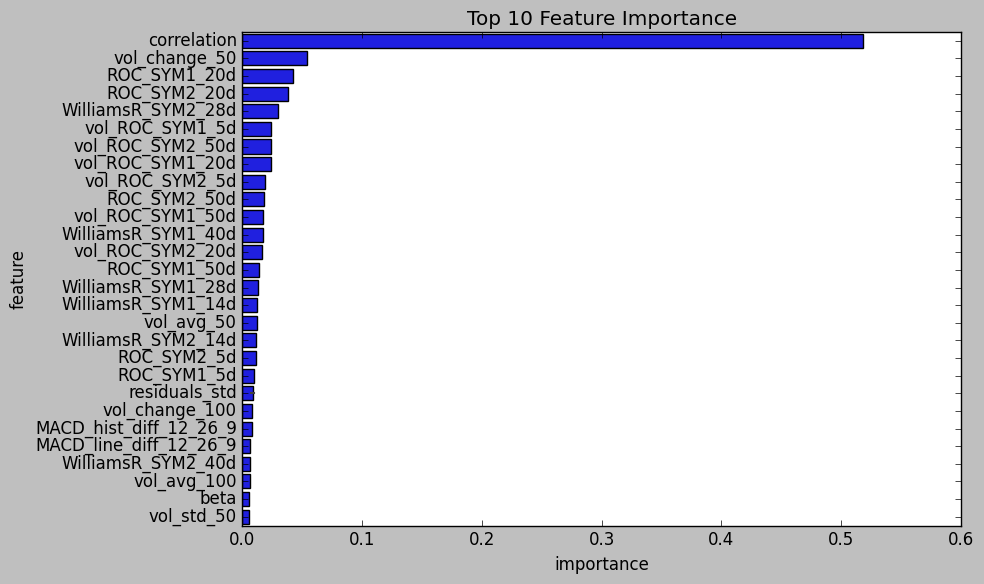

In [26]:
importance = pd.DataFrame({
    'feature': feature_columns,
    'importance': final_model_retrained.feature_importances_
}).sort_values('importance', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(data=importance.head(30), x='importance', y='feature')
plt.title('Top 10 Feature Importance')
plt.tight_layout()
plt.show()

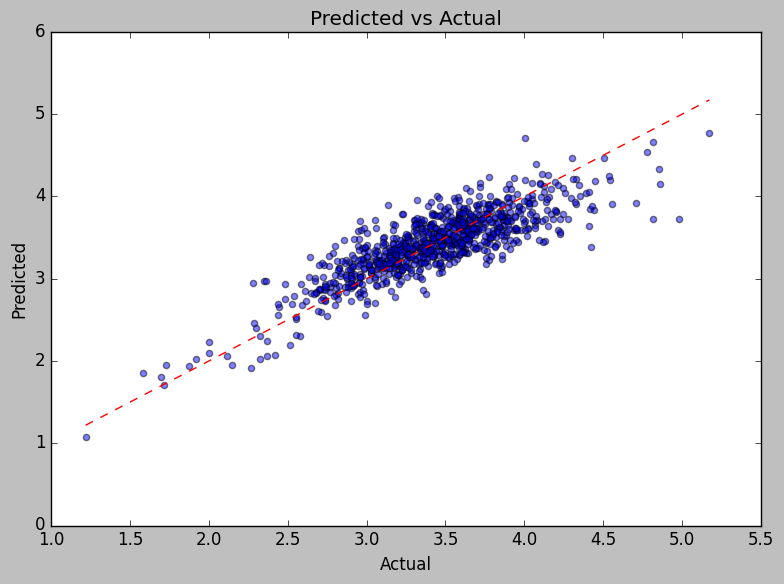

In [27]:
# Predicted vs Actual
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Predicted vs Actual')
plt.tight_layout()
plt.show()

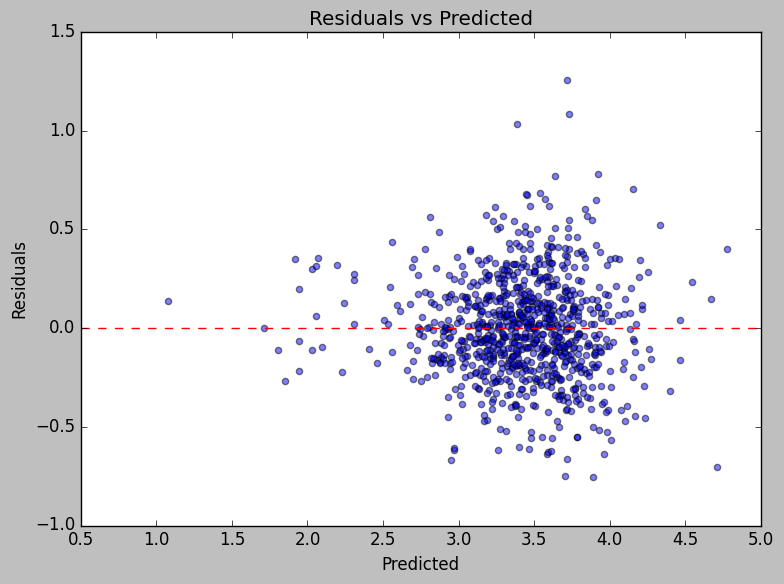

In [28]:
residuals = y_test - y_pred
plt.figure(figsize=(8, 6))
plt.scatter(y_pred, residuals, alpha=0.5)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('Predicted')
plt.ylabel('Residuals')
plt.title('Residuals vs Predicted')
plt.tight_layout()
plt.show()

### Walk-Forward Evaluation
```
walk_forward_dates = []
current_train_start = DATE_CONFIG['TRAIN_START']
current_train_end = DATE_CONFIG['TRAIN_END']
step_size = timedelta(days=90)  
while current_train_end <= DATE_CONFIG['TEST_END']:
    walk_forward_dates.append({
        'TRAIN_START': current_train_start,
        'TRAIN_END': current_train_end
    })
    current_train_start += step_size
    current_train_end += step_size

walk_forward_results = []

for wf_config in tqdm(walk_forward_dates, desc="Walk-Forward Iteration"):
    DATE_CONFIG['TRAIN_START'] = wf_config['TRAIN_START']
    DATE_CONFIG['TRAIN_END'] = wf_config['TRAIN_END']

    price_matrix, volume_matrix, symbols = load_and_prepare_data(config['data']['raw_data_path'])
    returns_matrix = price_matrix.pct_change().dropna()

    scaler = StandardScaler()
    standardized_returns = pd.DataFrame(
        scaler.fit_transform(returns_matrix),
        index=returns_matrix.index,
        columns=returns_matrix.columns
    )

    rolling_correlations = calculate_rolling_correlation(standardized_returns)
    rolling_correlations = rolling_correlations.dropna()
    rolling_betas = calculate_rolling_betas(standardized_returns)
    rolling_betas = rolling_betas.dropna()
    rolling_residuals_std = calculate_residuals_std(standardized_returns)
    rolling_residuals_std = rolling_residuals_std.dropna()
    average_spread_deviation = calculate_spread_deviation(standardized_returns)
    average_spread_deviation = average_spread_deviation.dropna()

    feature_df = pd.DataFrame({
        'correlation': rolling_correlations.iloc[-1],
        'beta': rolling_betas.iloc[-1],
        'residuals_std': rolling_residuals_std.iloc[-1]
    })
    feature_df['target'] = average_spread_deviation
    feature_df = feature_df.dropna()

    volume_features = calculate_volume_features(volume_matrix, rolling_correlations.columns)
    feature_df = pd.concat([feature_df[['correlation', 'beta', 'residuals_std', 'target']], volume_features], axis=1)
    roc_features = calculate_roc_features(price_matrix, volume_matrix, rolling_correlations.columns)
    feature_df = pd.concat([feature_df, roc_features], axis=1)
    williams_r_features = calculate_williams_r_features(price_matrix, rolling_correlations.columns)
    feature_df = pd.concat([feature_df, williams_r_features], axis=1)
    bollinger_bands_features = calculate_bollinger_bands_width(standardized_returns, rolling_correlations.columns)
    feature_df = pd.concat([feature_df, bollinger_bands_features], axis=1)
    macd_features = calculate_macd_features(price_matrix, rolling_correlations.columns)
    feature_df = pd.concat([feature_df, macd_features], axis=1)

    X = feature_df[feature_columns]
    y = feature_df['target']
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,
                                                        random_state=42)  # Beachte: Test hier ist Validierung im Walk-Forward

    best_params_grid_search = {'learning_rate': 0.2, 'max_depth': 2, 'min_samples_leaf': 2, 'min_samples_split': 2,
                               'n_estimators': 300}
    final_model_retrained = GradientBoostingRegressor(**best_params_grid_search, random_state=42)
    final_model_retrained.fit(X_train, y_train)
    y_pred = final_model_retrained.predict(X_test)

    results = {
        'TRAIN_START': str(DATE_CONFIG['TRAIN_START']),
        'TRAIN_END': str(DATE_CONFIG['TRAIN_END']),
        'R2': r2_score(y_test, y_pred),
        'MSE': mean_squared_error(y_test, y_pred),
        'MAE': mean_absolute_error(y_test, y_pred)
    }
    walk_forward_results.append(results)

walk_forward_df = pd.DataFrame(walk_forward_results)

print("\nWalk-Forward Validierungsergebnisse:")
print(walk_forward_df)


average_metrics = walk_forward_df[['R2', 'MSE', 'MAE']].mean()
print("\nDurchschnittliche Metriken über alle Walk-Forward-Schritte:")
print(average_metrics)

plt.figure(figsize=(12, 6))
plt.plot(walk_forward_df['TRAIN_END'], walk_forward_df['R2'], label='R2')
plt.plot(walk_forward_df['TRAIN_END'], walk_forward_df['MSE'], label='MSE')
plt.plot(walk_forward_df['TRAIN_END'], walk_forward_df['MAE'], label='MAE')
plt.xlabel('Train End Date')
plt.ylabel('Metrics')
plt.title('Walk-Forward Validierung Metriken')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
```

In [29]:
def trade(S1_train, S2_train, S1_test, S2_test, symbol1, symbol2, window_number, window=bb_window, hr_window=hr_window, hr_recalc=hr_recalc, std_dev=std_dev):
    trades = []
    trade_id = 0
    active_trades = []  
    
    S1_full = pd.concat([S1_train, S1_test])
    S2_full = pd.concat([S2_train, S2_test])
    
    days_since_recalc = 0
    current_hedge_ratio = None
    
    for i in range(len(S1_test)):
        current_idx = S1_train.shape[0] + i
        current_date = S1_test.index[i]
        
        if days_since_recalc >= hr_recalc or current_hedge_ratio is None:
            if current_idx >= hr_window:
                hr_data_1 = S1_full.iloc[current_idx-hr_window:current_idx]
                hr_data_2 = S2_full.iloc[current_idx-hr_window:current_idx]
                
                valid_idx = hr_data_1.notna() & hr_data_2.notna()
                
                if valid_idx.sum() > 1:
                    hr_data_1_valid = hr_data_1[valid_idx]
                    hr_data_2_valid = hr_data_2[valid_idx]
                    
                    model = sm.OLS(hr_data_1_valid, hr_data_2_valid)
                    try:
                        current_hedge_ratio = model.fit().params[0]
                        days_since_recalc = 0
                    except:
                        pass
        
        days_since_recalc += 1
        
        if current_hedge_ratio is None:
            continue
            
        spread_full = S1_full - (S2_full * current_hedge_ratio)
        spread_window = spread_full.iloc[:current_idx+1]
        
        if len(spread_window) < window:
            continue
            
        rolling_mean = spread_window.rolling(window=window).mean().iloc[-1]
        rolling_std = spread_window.rolling(window=window).std().iloc[-1]
        
        if pd.isna(rolling_std) or rolling_std == 0:
            continue
            
        upper_band = rolling_mean + (rolling_std * std_dev)
        lower_band = rolling_mean - (rolling_std * std_dev)
        
        current_spread = spread_full.iloc[current_idx]

        if current_spread > upper_band:
            trade_entry = {
                'trade_id': trade_id,
                'symbol1': symbol1,  # Add explicit symbol1 field
                'symbol2': symbol2,  # Add explicit symbol2 field
                'entry_date': current_date,
                'type': 'short',
                'status': 'active',
                'entry_prices': {
                    symbol1: {'price': S1_test.iloc[i], 'type': 'short'},
                    symbol2: {'price': S2_test.iloc[i], 'type': 'long'}
                },
                'hedge_ratio': current_hedge_ratio,
                'window': window_number
            }
            active_trades.append(trade_entry)
            trade_id += 1
            
        elif current_spread < lower_band:
            trade_entry = {
                'trade_id': trade_id,
                'symbol1': symbol1,  # Add explicit symbol1 field
                'symbol2': symbol2,  # Add explicit symbol2 field
                'entry_date': current_date,
                'type': 'long', 
                'status': 'active',
                'entry_prices': {
                    symbol1: {'price': S1_test.iloc[i], 'type': 'long'},
                    symbol2: {'price': S2_test.iloc[i], 'type': 'short'}
                },
                'hedge_ratio': current_hedge_ratio,
                'window': window_number
            }
            active_trades.append(trade_entry)
            trade_id += 1

        for trade in active_trades:
            if trade['status'] == 'active':
                if (trade['type'] == 'short' and current_spread < rolling_mean) or \
                   (trade['type'] == 'long' and current_spread > rolling_mean):
                    
                    trade['status'] = 'closed'
                    
                    for symbol in [symbol1, symbol2]:
                        trades.append({
                            'trade_id': trade['trade_id'],
                            'symbol': symbol,
                            'entry_date': trade['entry_date'],
                            'entry_price': trade['entry_prices'][symbol]['price'],
                            'exit_date': current_date,
                            'exit_price': S1_test.iloc[i] if symbol == symbol1 else S2_test.iloc[i],
                            'position_type': trade['entry_prices'][symbol]['type'],
                            'paired_symbol': symbol2 if symbol == symbol1 else symbol1,
                            'exit_type': 'target',
                            'window': trade['window'],
                            'hedge_ratio': trade['hedge_ratio']
                        })

    return trades, [t for t in active_trades if t['status'] == 'active']

In [30]:
def backtest_pairs_sliding(price_matrix, initial_start_date, initial_end_date, base_output_path=base_output_path, output_filename=output_filename, window_shifts=window_shifts, p_threshold=p_threshold, shift_size=shift_size):
   all_trades = []
   ongoing_trades = []
   
   print(f"Price Matrix Zeitraum: {price_matrix.index.min()} bis {price_matrix.index.max()}")
   
   symbols = price_matrix.columns.tolist()
   
   for window_number in range(window_shifts):
       if window_number == 0:
           current_start = initial_start_date
           current_end = initial_end_date
       else:
           current_start = initial_start_date + pd.DateOffset(months=window_number*shift_size)
           current_end = initial_end_date + pd.DateOffset(months=window_number*shift_size)
       
       print(f"\nAnalyse {window_number+1}/{window_shifts}")
       print(f"Cluster-Fenster: {current_start} bis {current_end}")
       
       cluster_data = price_matrix[(price_matrix.index >= current_start) & 
                                 (price_matrix.index <= current_end)].copy()
       
       if len(cluster_data) == 0:
           print(f"Keine Daten für Fenster {window_number+1}")
           continue
           
       print(f"Cluster Daten: {len(cluster_data)} Tage")
       
       returns_matrix = cluster_data.pct_change()
       returns_matrix = returns_matrix.dropna()
       
       scaler = StandardScaler()
       standardized_returns = pd.DataFrame(
           scaler.fit_transform(returns_matrix),
           index=returns_matrix.index,
           columns=returns_matrix.columns
       )
       
       rolling_correlations = calculate_rolling_correlation(standardized_returns)
       rolling_correlations = rolling_correlations.dropna()
       rolling_betas = calculate_rolling_betas(standardized_returns)
       rolling_betas = rolling_betas.dropna()
       rolling_residuals_std = calculate_residuals_std(standardized_returns)
       rolling_residuals_std = rolling_residuals_std.dropna()
       average_spread_deviation = calculate_spread_deviation(standardized_returns)
       average_spread_deviation = average_spread_deviation.dropna()

       feature_df = pd.DataFrame({
           'correlation': rolling_correlations.iloc[-1],
           'beta': rolling_betas.iloc[-1],
           'residuals_std': rolling_residuals_std.iloc[-1]
       })
       feature_df['target'] = average_spread_deviation
       feature_df = feature_df.dropna()

       volume_matrix = price_matrix.copy()
       
       volume_features = calculate_volume_features(volume_matrix, rolling_correlations.columns)
       roc_features = calculate_roc_features(cluster_data, volume_matrix, rolling_correlations.columns)
       williams_r_features = calculate_williams_r_features(cluster_data, rolling_correlations.columns)
       bollinger_bands_features = calculate_bollinger_bands_width(standardized_returns, rolling_correlations.columns)
       macd_features = calculate_macd_features(cluster_data, rolling_correlations.columns)

       feature_df = pd.concat([
           feature_df[['correlation', 'beta', 'residuals_std', 'target']],
           volume_features,
           roc_features,
           williams_r_features,
           bollinger_bands_features,
           macd_features
       ], axis=1)

       X = feature_df[feature_columns]
       y = feature_df['target']
       
       imputer = SimpleImputer(strategy='mean')
       X_imputed = pd.DataFrame(
           imputer.fit_transform(X),
           columns=X.columns,
           index=X.index
       )
               
       best_params_grid_search = {
           'learning_rate': learning_rate, 
           'max_depth': max_depth, 
           'min_samples_leaf': min_samples_leaf, 
           'min_samples_split': min_samples_split,
           'n_estimators': n_estimators
       }
       model = GradientBoostingRegressor(**best_params_grid_search, random_state=42)
       model.fit(X_imputed, y)
       
       potential_pairs = []
       for i in range(len(symbols)):
           for j in range(i+1, len(symbols)):
               symbol1, symbol2 = symbols[i], symbols[j]
               
               series1 = cluster_data[symbol1]
               series2 = cluster_data[symbol2]

               valid_idx = series1.notna() & series2.notna()

               if valid_idx.sum() > 30:
                   series1_clean = series1[valid_idx]
                   series2_clean = series2[valid_idx]
                   
                   try:
                       score, pvalue, _ = coint(series1_clean, series2_clean)
                       
                       if pvalue < p_threshold:
                           pair_key = f"{symbol1}_{symbol2}"
                           if pair_key in feature_df.index:
                               X_row = X.loc[[pair_key]]
                               X_row_imputed = pd.DataFrame(
                                   imputer.transform(X_row),
                                   columns=X_row.columns,
                                   index=X_row.index
                               )
                               potential_pairs.append({
                                   'pair': (symbol1, symbol2),
                                   'pvalue': pvalue,
                                   'predicted_spread': model.predict(X_row_imputed)[0]
                               })
                   except:
                       continue
       
       if not potential_pairs:
           print(f"Keine kointegrierten Paare gefunden für Fenster {window_number+1}")
           continue
           
       pairs_df = pd.DataFrame(potential_pairs)
       pairs_df = pairs_df.sort_values('predicted_spread')
       top_pairs = pairs_df['pair'].tolist()[:min_pairs]
       
       print(f"Gefundene handelbare Paare für Fenster {window_number+1}: {len(top_pairs)}")
       
       trade_start = current_end
       trade_end = min(trade_start + pd.DateOffset(months=shift_size), price_matrix.index.max())
       
       print(f"Trading-Zeitraum: {trade_start} bis {trade_end}")
       
       trading_data = price_matrix[(price_matrix.index > trade_start) & 
                                 (price_matrix.index <= trade_end)].copy()
       
       print(f"Trading Daten: {len(trading_data)} Tage")
       
       if len(trading_data) == 0:
           print(f"Warnung: Kein Trading-Zeitraum verfügbar nach {trade_start}")
           continue
           
       updated_ongoing_trades = []
       closed_trade_ids = set()
       
       for open_trade in ongoing_trades:
           symbol1, symbol2 = open_trade['symbol1'], open_trade['symbol2']
           
           if symbol1 in trading_data.columns and symbol2 in trading_data.columns:
               still_active = True
               
               for idx, date in enumerate(trading_data.index):
                   train_data = price_matrix[(price_matrix.index <= open_trade['entry_date'])]
                   ratio_history = train_data[symbol1] / train_data[symbol2]
                   
                   if len(ratio_history) >= bb_window:
                       ma = ratio_history.rolling(window=bb_window, center=False).mean().iloc[-1]
                       std = ratio_history.rolling(window=bb_window, center=False).std().iloc[-1]
                   else:
                       ma = ratio_history.mean()
                       std = ratio_history.std()
                   
                   if std == 0:
                       continue
                   
                   current_ratio = trading_data[symbol1].iloc[idx] / trading_data[symbol2].iloc[idx]
                   current_zscore = (current_ratio - ma) / std
                   
                   if (open_trade['type'] == 'short' and current_zscore < 0.5) or \
                      (open_trade['type'] == 'long' and current_zscore > -0.5):
                       
                       open_trade['status'] = 'closed'
                       open_trade['exit_date'] = date
                       closed_trade_ids.add(open_trade['trade_id'])
                       
                       for symbol in [symbol1, symbol2]:
                           all_trades.append({
                               'trade_id': open_trade['trade_id'],
                               'symbol': symbol,
                               'entry_date': open_trade['entry_date'],
                               'entry_price': open_trade['entry_prices'][symbol]['price'],
                               'exit_date': date,
                               'exit_price': trading_data.loc[date, symbol],
                               'position_type': open_trade['entry_prices'][symbol]['type'],
                               'paired_symbol': symbol2 if symbol == symbol1 else symbol1,
                               'exit_type': 'target',
                               'window': open_trade['window']
                           })
                       
                       still_active = False
                       break
               
               if still_active:
                   updated_ongoing_trades.append(open_trade)
       
       ongoing_trades = updated_ongoing_trades
       
       trade_count = 0
       for pair in top_pairs:
           symbol1, symbol2 = pair
           
           if symbol1 not in trading_data.columns or symbol2 not in trading_data.columns:
               continue
               
           new_trades, active_new_trades = trade(
               cluster_data[symbol1],
               cluster_data[symbol2],
               trading_data[symbol1],
               trading_data[symbol2],
               symbol1, symbol2,
               window_number=window_number+1,
               window=bb_window,
               hr_window=hr_window,
               hr_recalc=hr_recalc,
               std_dev=std_dev
           )
           
           if new_trades:
               trade_count += len(new_trades) // 2
               all_trades.extend(new_trades)
           
           ongoing_trades.extend(active_new_trades)
       
       print(f"Neue geschlossene Trades in diesem Fenster: {trade_count}")
       print(f"Aktuell offene Trades: {len(ongoing_trades)}")
   
   trades_df = pd.DataFrame(all_trades)
   
   if len(trades_df) > 0:
       full_output_path = f"{base_output_path}{output_filename}"
       trades_df.to_parquet(full_output_path)
       
       print("\nTrading Zusammenfassung:")
       print(f"Gesamtanzahl Trades: {len(trades_df)}")
       print(f"Unique Paare gehandelt: {len(trades_df[['symbol', 'paired_symbol']].drop_duplicates())}")
       print(f"Zeitraum: {trades_df['entry_date'].min()} bis {trades_df['exit_date'].max()}")
       
       print("\nTrades pro Fenster:")
       print(trades_df['window'].value_counts().sort_index())
   else:
       print("Keine Trades generiert!")
       
   return trades_df

In [31]:
trades_df = backtest_pairs_sliding(
    price_matrix=price_matrix,
    initial_start_date=DATE_CONFIG['TRAIN_START'],
    initial_end_date=DATE_CONFIG['TRAIN_END'], 
    base_output_path=base_output_path,
    output_filename=output_filename,
    window_shifts=window_shifts,
    p_threshold=p_threshold,
    shift_size=shift_size
)

Price Matrix Zeitraum: 2021-02-02 00:00:00 bis 2024-12-31 00:00:00

Analyse 1/12
Cluster-Fenster: 2021-02-02 00:00:00 bis 2024-01-01 00:00:00
Cluster Daten: 733 Tage
Gefundene handelbare Paare für Fenster 1: 20
Trading-Zeitraum: 2024-01-01 00:00:00 bis 2024-02-01 00:00:00
Trading Daten: 22 Tage
Neue geschlossene Trades in diesem Fenster: 49
Aktuell offene Trades: 111

Analyse 2/12
Cluster-Fenster: 2021-03-02 00:00:00 bis 2024-02-01 00:00:00
Cluster Daten: 736 Tage
Gefundene handelbare Paare für Fenster 2: 20
Trading-Zeitraum: 2024-02-01 00:00:00 bis 2024-03-01 00:00:00
Trading Daten: 20 Tage
Neue geschlossene Trades in diesem Fenster: 9
Aktuell offene Trades: 273

Analyse 3/12
Cluster-Fenster: 2021-04-02 00:00:00 bis 2024-03-01 00:00:00
Cluster Daten: 733 Tage
Gefundene handelbare Paare für Fenster 3: 20
Trading-Zeitraum: 2024-03-01 00:00:00 bis 2024-04-01 00:00:00
Trading Daten: 20 Tage
Neue geschlossene Trades in diesem Fenster: 39
Aktuell offene Trades: 311

Analyse 4/12
Cluster-Fen